<a href="https://colab.research.google.com/github/benmsanderson/SCM_MLtuner/blob/main/1%20-%20FAIR_EEI_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
pip install fair

## 0. Get required imports

[pooch](https://www.fatiando.org/pooch/latest/) is a useful package that allows downloads of external datasets to your cache, meaning that you don't have to include them in Git repositories (particularly troublesome for large files) or `.gitignore` them (difficult for exact reproduciblity, and easy to forget and accidently commit a large file).

In [3]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Create FaIR instance


In [5]:
f = FAIR(ch4_method="Thornhill2021")
## 2. Define time horizon

f.define_time(1750, 2300, 1)  # start, end, step
## 3. Define scenarios

#scenarios = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp534-over", "ssp585"]
scenarios = ["ssp245"]
f.define_scenarios(scenarios)

## 4. Define configs



In [6]:
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/8399112/files/calibrated_constrained_parameters.csv',
    known_hash = 'md5:de3b83432b9d071efdd1427ad31e9076',
)

In [7]:
df_org = pd.read_csv(fair_params_1_2_0_obj, index_col=0)



In [8]:
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=len(df_org.columns))
sample = sampler.random(n=20000)

In [9]:
sample_scaled = qmc.scale(sample, df_org.min(), df_org.max())

In [10]:
df_configs = pd.DataFrame(sample_scaled, columns=df_org.columns)
configs = df_configs.index  # this is used as a label for the "config" axis


In [11]:
f.define_configs(configs)

Make a config dataframe with half kappa2 values

In [12]:
#df_configs_highsens['clim_kappa1']=df_configs['clim_kappa1']/2
#df_configs_highsens['aci_beta']=df_configs['aci_beta']*2


In [13]:

species, properties = read_properties(filename='https://raw.githubusercontent.com/OMS-NetZero/FAIR/master/examples/data/species_configs_properties_calibration1.2.0.csv')
f.define_species(species, properties)

f.allocate()

## 8. Fill in data

### 8a. emissions, solar forcing, and volcanic forcing

We can use the convenience function `fill_from_rcmip()` to fill in the emissions. Remember that not all `species` are things that take emissions, so if you see NaNs below, don't panic.

In [14]:
f.fill_from_rcmip()

Fix Nox

In [15]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)
df_emis = pd.read_csv(rcmip_emissions_file)
gfed_sectors = [
    "Emissions|NOx|MAGICC AFOLU|Agricultural Waste Burning",
    "Emissions|NOx|MAGICC AFOLU|Forest Burning",
    "Emissions|NOx|MAGICC AFOLU|Grassland Burning",
    "Emissions|NOx|MAGICC AFOLU|Peat Burning",
]
for scenario in scenarios:
    f.emissions.loc[dict(specie="NOx", scenario=scenario)] = (
        df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"].isin(gfed_sectors)),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        .sum(axis=0)
        * 46.006
        / 30.006
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC AFOLU|Agriculture"),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC Fossil and Industrial"),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
    )[:550, None]

Now we fetch and fill in the solar and volcanic forcing. As these are forcing-driven time series, if we want to vary the uncertainties in the forcing, this has to happen before FaIR is run (see https://github.com/OMS-NetZero/FAIR/issues/126).

In [16]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [17]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

In [18]:
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj)

Remembering that everything that is not emissions is on `timebounds`, there is always one more `timebounds` than `timepoints`, so we define arrays of length 551 (1750 to 2300, inclusive).

Volcanic forcing is given monthly, so we average the 12 previous months for each `timebounds` volcanic forcing.

Volcanic forcing here follows the CMIP6 ScenarioMIP convention of a 10 year ramp down to zero from the last year of data (here 2019). Again a little bit of ninja skill with indexing is needed.

In [19]:
solar_forcing = np.zeros(551)
volcanic_forcing = np.zeros(551)
volcanic_forcing[:352] = df_volcanic.erf.values
solar_forcing = df_solar["erf"].loc[1750:2300].values

trend_shape = np.ones(551)
trend_shape[:271] = np.linspace(0, 1, 271)

We then use our calibrated, constrained ensemble to individually scale the volcanic forcing time series, and the solar amplitude and trend:

In [20]:
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

### 8b. Fill in climate_configs

This is relatively straightforward from the calibrated, constrained dataset.

In [21]:
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)

fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], False)
fill(f.climate_configs["use_seed"], False)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

In [22]:
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)

### 8c. Fill in species_configs

Firstly we want to get the defaults from our new species/properties/configs file

In [23]:
f.fill_species_configs(filename='https://raw.githubusercontent.com/OMS-NetZero/FAIR/master/examples/data/species_configs_properties_calibration1.2.0.csv')

Then, we overwrite the `species_configs` that are varies as part of the probablistic sampling. This makes heavy use of the `fill()` convenience function.

In [24]:
# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_airborne"], df_configs["cc_rA"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_temperature"], df_configs["cc_rT"].values.squeeze(), specie="CO2")

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
fill(f.species_configs["aci_shape"], df_configs["aci_shape_so2"].values.squeeze(), specie="Sulfur")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_bc"].values.squeeze(), specie="BC")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_oc"].values.squeeze(), specie="OC")

# aerosol direct
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine"
]:
    fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari_{specie}"], specie=specie)

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Contrails",
    "Light absorbing particles on snow and ice",
    "Land use"
]:
    fill(f.species_configs["forcing_scale"], df_configs[f"fscale_{specie}"].values.squeeze(), specie=specie)
# the halogenated gases all take the same scale factor
for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(f.species_configs["forcing_scale"], df_configs["fscale_minorGHG"].values.squeeze(), specie=specie)

# ozone
for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
    fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3_{specie}"], specie=specie)

# initial value of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"],
    df_configs["cc_co2_concentration_1750"].values.squeeze(),
    specie="CO2"
)

### 8d. Initial conditions

It's important these are defined, as they are NaN by default, and it's likely you'll run into problems.

In [25]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## 9. Run

In [26]:
f.run()


Running 20000 projections in parallel:   0%|          | 0/550 [00:00<?, ?timesteps/s]

## 10. Analysis

In [27]:
fancy_titles = {
    "ssp119": "SSP1-1.9",
    "ssp126": "SSP1-2.6",
    "ssp245": "SSP2-4.5",
    "ssp370": "SSP3-7.0",
    "ssp434": "SSP4-3.4",
    "ssp460": "SSP4-6.0",
    "ssp534-over": "SSP5-3.4-overshoot",
    "ssp585": "SSP5-8.5",
}

ar6_colors = {
    "ssp119": "#00a9cf",
    "ssp126": "#003466",
    "ssp245": "#f69320",
    "ssp370": "#df0000",
    "ssp434": "#2274ae",
    "ssp460": "#b0724e",
    "ssp534-over": "#92397a",
    "ssp585": "#980002",
}

## Energetic Imbalance

In [28]:
tsrc=['HadCRUT5','NOAAGlobalTemp','GISTEMP','ERA5','JRA-55','Berkeley%20Earth']
tmp=[]
for ts in tsrc:
  gtas=pd.read_csv('https://climate.metoffice.cloud/formatted_data/gmt_'+ts+'.csv')
  gtas['Date']=pd.to_datetime([f'{y}-06-01' for y in gtas.Year])
  gtas=gtas.set_index('Date')
  tmp.append(gtas[ts.replace('%20',' ')+' (degC)'])
gta=pd.concat(tmp,axis=1)

<Axes: xlabel='Date'>

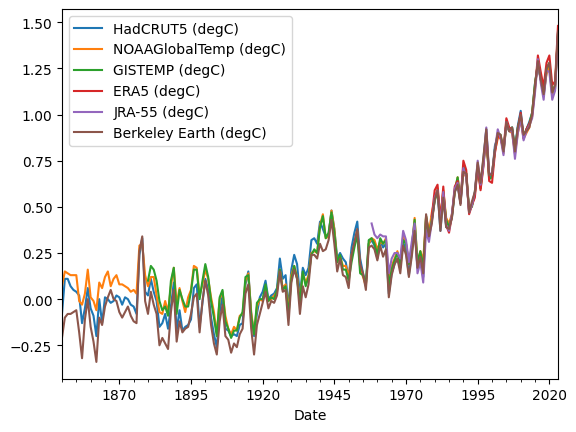

In [29]:
gta.plot()

In [30]:
gco2=pd.read_csv('https://climate.metoffice.cloud/formatted_data/co2_Mauna%20Loa%20CO2.csv')

gco2['Date']=pd.to_datetime([f'{y}-{m}-01' for y, m in zip(gco2.Year, gco2.Month)])
gco2=gco2.set_index('Date')

<Axes: xlabel='Date'>

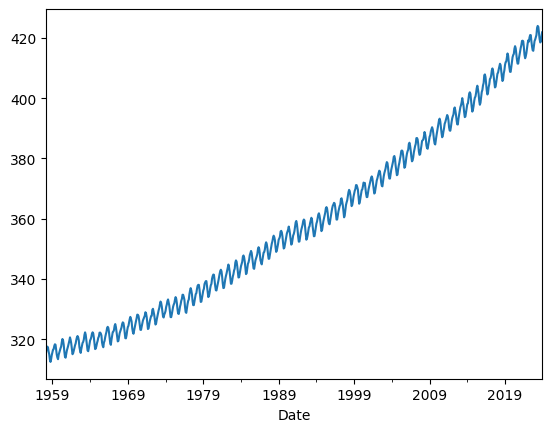

In [31]:
gco2['Mauna Loa CO2 (ppm)'].plot()

In [32]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

In [33]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1idf_WRF9f6YiNA-TtNTFxqZuu56dB9iH' -O CERES-EBAF.nc

--2024-03-20 15:52:48--  https://docs.google.com/uc?export=download&id=1idf_WRF9f6YiNA-TtNTFxqZuu56dB9iH
Resolving docs.google.com (docs.google.com)... 108.177.119.113, 108.177.119.139, 108.177.119.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1idf_WRF9f6YiNA-TtNTFxqZuu56dB9iH&export=download [following]
--2024-03-20 15:52:48--  https://drive.usercontent.google.com/download?id=1idf_WRF9f6YiNA-TtNTFxqZuu56dB9iH&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.218.132, 2a00:1450:4013:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.218.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11092 (11K) [application/octet-stream]
Saving to: ‘CERES-EBAF.nc’

CERES-EBAF.nc       100%[===================>]  10.83K  --.-KB/s   

In [34]:
cdf=xr.open_dataset('CERES-EBAF.nc')

In [35]:
ctoa=cdf.gtoa_net_all_mon.rolling(time=12, center=True).mean().dropna("time")

Text(0, 0.5, 'Warming in 2100, SSP2-45 emissions-driven (K)')

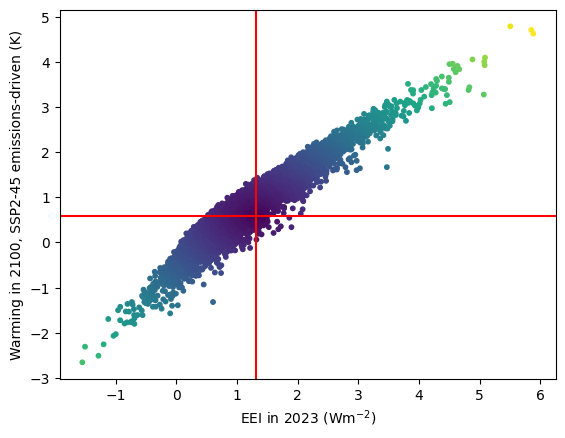

In [36]:

 raderr=np.sqrt((f.toa_imbalance.loc[dict(scenario='ssp245',timebounds=2020)]-ctoa.sel(time=slice('2018-01-01', '2024-01-01')).mean())**2+
         (f.toa_imbalance.loc[dict(scenario='ssp245',timebounds=2005)]-ctoa.sel(time=slice('2000-01-01', '2010-01-01')).mean())**2)

 plt.scatter(f.toa_imbalance.loc[dict(scenario='ssp245',timebounds=2020)],f.toa_imbalance.loc[dict(scenario='ssp245',timebounds=2005)],10,raderr)
 plt.axvline(ctoa.sel(time=slice('2018-01-01', '2024-01-01')).mean(),color='r')
 plt.axhline(ctoa.sel(time=slice('2000-01-01', '2010-01-01')).mean(),color='r')
 plt.xlabel('EEI in 2023 (Wm$^{-2}$)')
 plt.ylabel('Warming in 2100, SSP2-45 emissions-driven (K)')

In [37]:
raderr<np.min(raderr)*1.01

<xarray.DataArray (config: 20000)>
array([False, False, False, ..., False, False, False])
Coordinates:
    scenario  <U6 'ssp245'
  * config    (config) int64 0 1 2 3 4 5 ... 19994 19995 19996 19997 19998 19999

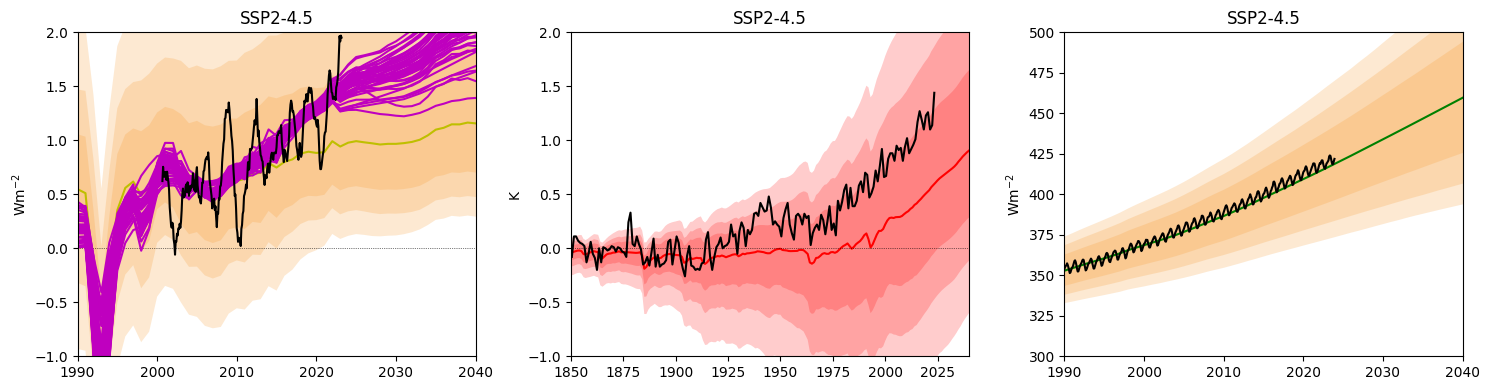

In [38]:
fig, ax = pl.subplots(1, 3, figsize=(15, 4))

scenario='ssp245'
for pp in ((1, 99), (5, 95), (16, 84)):
    ax[0].fill_between(
        f.timebounds,
        np.percentile(
            f.toa_imbalance.loc[dict(scenario=scenario)],
            pp[0],
            axis=1,
        ),
        np.percentile(
            f.toa_imbalance.loc[dict(scenario=scenario)],
            pp[1],
            axis=1,
        ),
        color=ar6_colors[scenario],
        alpha=0.2,
        lw=0
    )

ax[0].plot(
    f.timebounds,
    np.median(
        f.toa_imbalance.loc[dict(scenario=scenario)],
        axis=1,
    ),
    color='y',
)
ax[0].set_xlim(1990, 2040)
ax[0].set_ylim(-1, 2)
ax[0].axhline(0, color="k", ls=":", lw=0.5)
ax[0].set_title(fancy_titles[scenario])
ax[0].set_ylabel('Wm$^{-2}$')
ax[0].plot(f.timebounds,f.toa_imbalance.loc[dict(scenario=scenario)][:,raderr<(np.min(raderr)*10)],'m')
ax[0].plot(ctoa.time.values.astype('datetime64[M]').astype(float)/12+1970,ctoa,color='black')



for pp in ((1, 99), (5, 95), (16, 84)):
    ax[1].fill_between(
        f.timebounds,
        np.percentile(
            f.temperature.loc[dict(scenario=scenario)][:,:,0],
            pp[0],
            axis=1,
        ),
        np.percentile(
            f.temperature.loc[dict(scenario=scenario)][:,:,0],
            pp[1],
            axis=1,
        ),
        color='r',
        alpha=0.2,
        lw=0
    )

ax[1].plot(
    f.timebounds,
    np.median(
        f.temperature.loc[dict(scenario=scenario)][:,:,0],
        axis=1,
    ),
    color='r',
)
ax[1].set_xlim(1850, 2040)
ax[1].set_ylim(-1, 2)
ax[1].axhline(0, color="k", ls=":", lw=0.5)
ax[1].set_title(fancy_titles[scenario])
ax[1].set_ylabel('K')

ax[1].plot(gta.index.values.astype('datetime64[M]').astype(float)/12+1970,gta['HadCRUT5 (degC)'],color='black')



for pp in ((1, 99), (5, 95), (16, 84)):
    ax[2].fill_between(
        f.timebounds,
        np.percentile(
            f.concentration.loc[dict(scenario=scenario,specie='CO2')],
            pp[0],
            axis=1,
        ),
        np.percentile(
            f.concentration.loc[dict(scenario=scenario,specie='CO2')],
            pp[1],
            axis=1,
        ),
        color=ar6_colors[scenario],
        alpha=0.2,
        lw=0
    )

ax[2].plot(
    f.timebounds,
    np.median(
        f.concentration.loc[dict(scenario=scenario,specie='CO2')],
        axis=1,
    ),
    color='g',
)
ax[2].set_xlim(1990, 2040)
ax[2].set_ylim(300, 500)

ax[2].axhline(0, color="k", ls=":", lw=0.5)
ax[2].set_title(fancy_titles[scenario])
ax[2].set_ylabel('Wm$^{-2}$')

ax[2].plot(gco2.index.values.astype('datetime64[M]').astype(float)/12+1970,gco2['Mauna Loa CO2 (ppm)'],color='black')


fig.tight_layout()



Text(0, 0.5, 'Warming in 2100, SSP2-45 emissions-driven (K)')

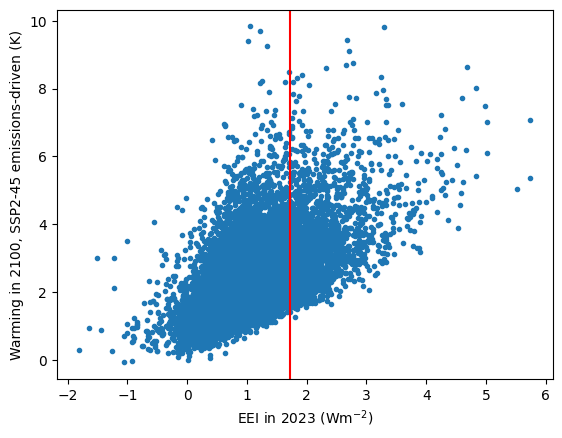

In [39]:
 plt.plot(f.toa_imbalance.loc[dict(scenario='ssp245',timebounds=2018)],f.temperature.loc[dict(scenario='ssp245',timebounds=2100,layer=0)],'.')
 plt.axvline(ctoa[-10:].mean(),color='r')
 plt.xlabel('EEI in 2023 (Wm$^{-2}$)')
 plt.ylabel('Warming in 2100, SSP2-45 emissions-driven (K)')


plot EEI mean vs parameters

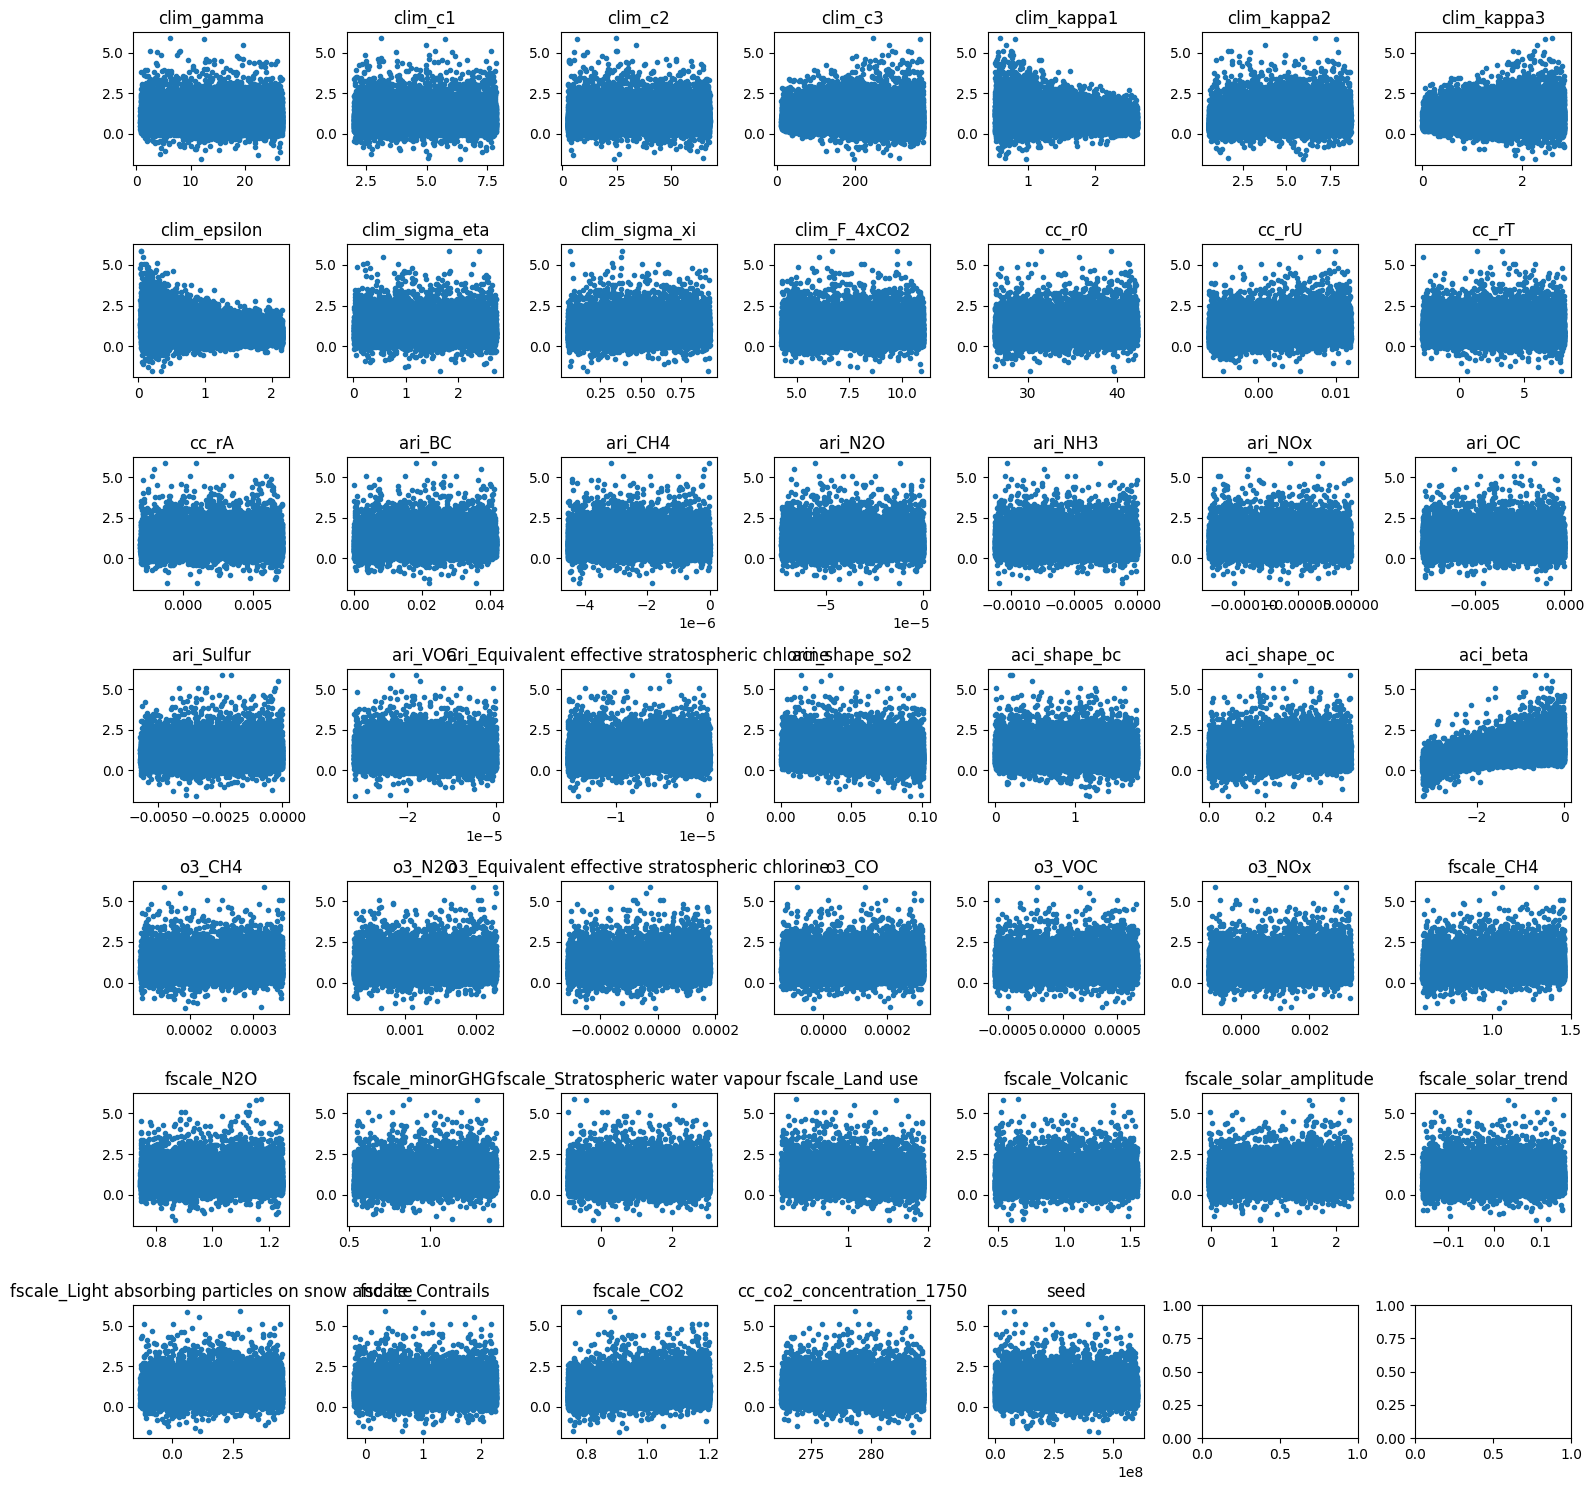

In [40]:
fig, ax = pl.subplots(7, 7, figsize=(15, 15))
ax=ax.flatten()
for i,prm in enumerate(df_configs.columns):
  ax[i].plot(df_configs[prm],f.toa_imbalance.loc[dict(scenario='ssp245',timebounds=2020)],'.')
  ax[i].set_title(prm)
plt.tight_layout()

plot rate of change vs parameters


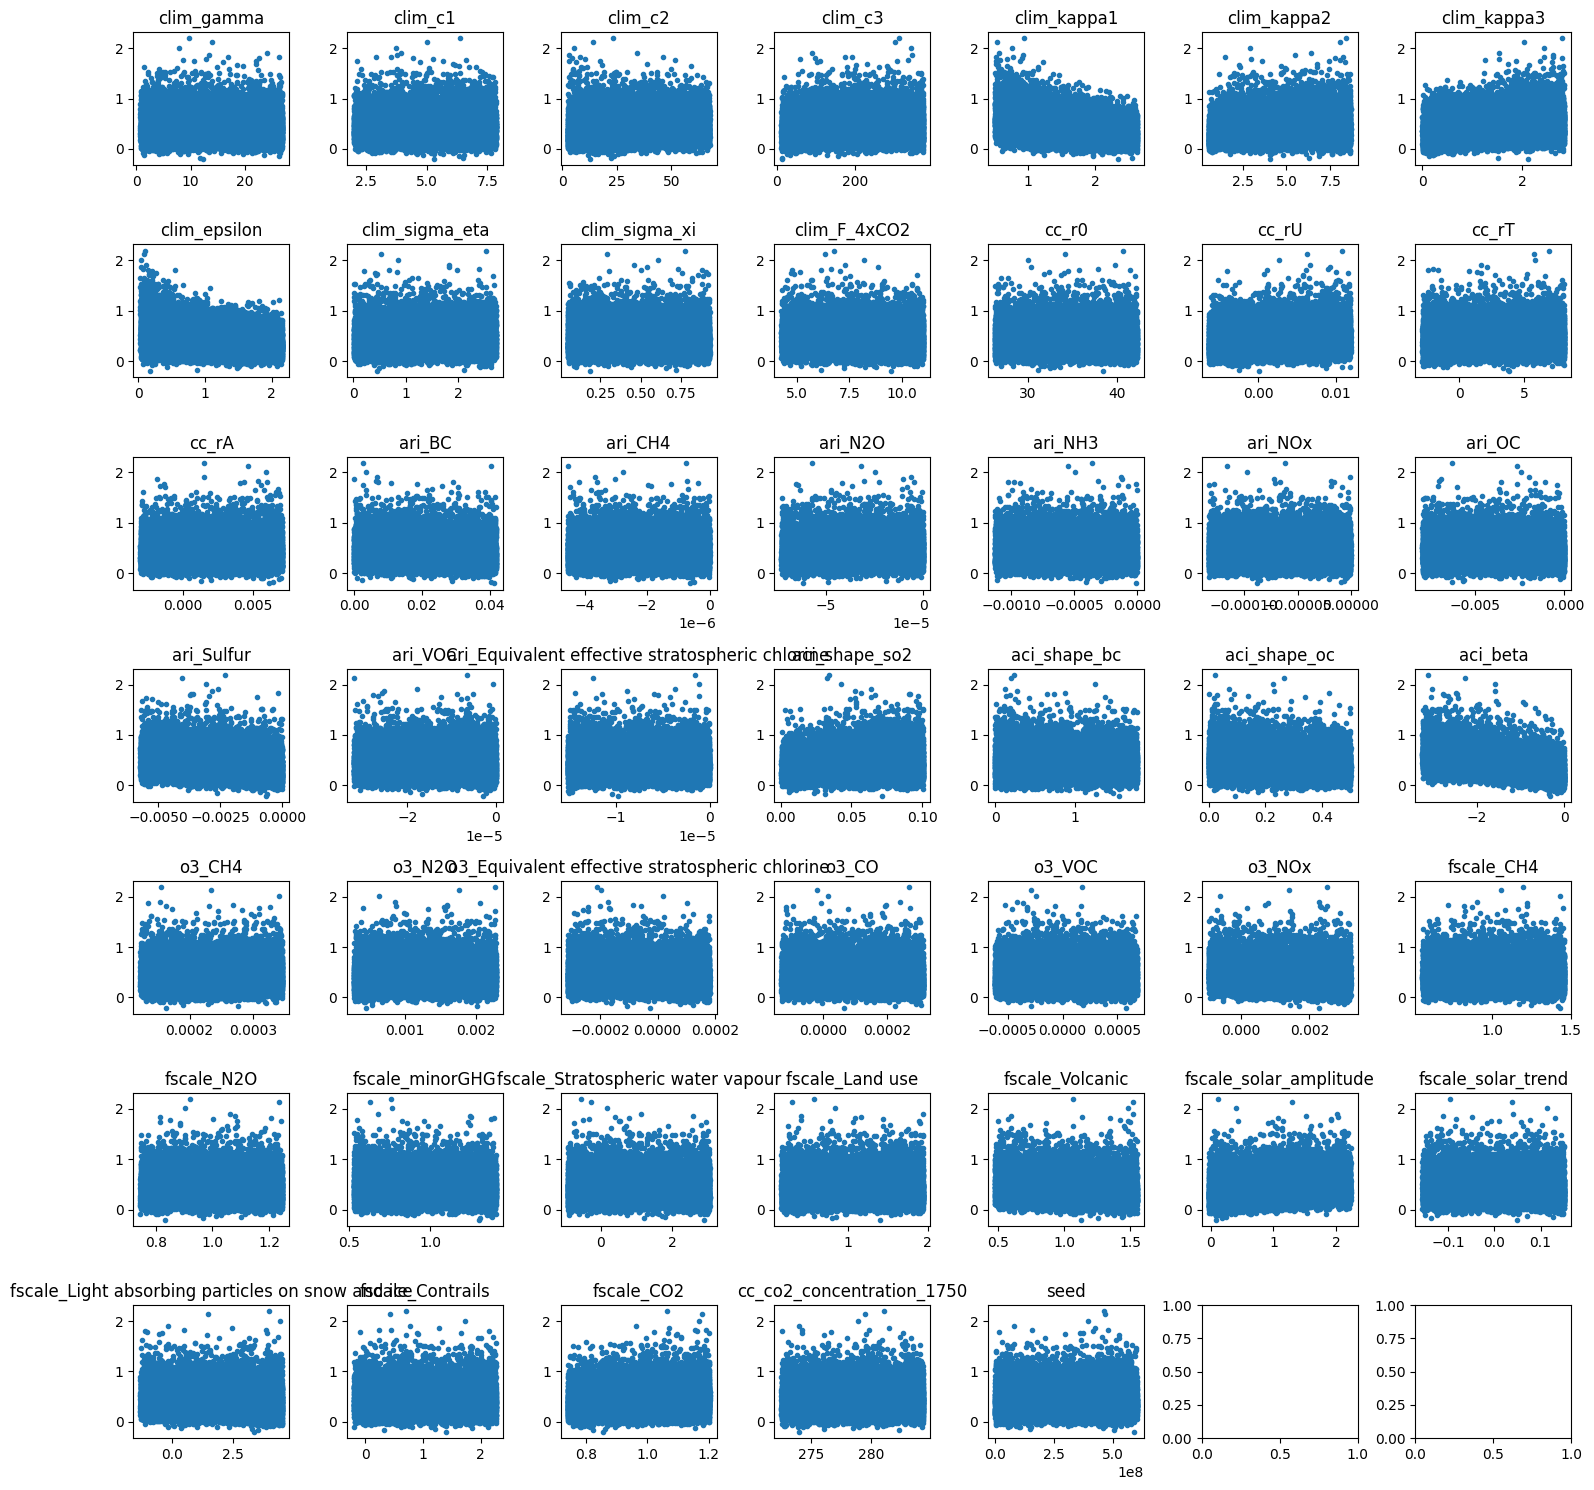

In [41]:
fig, ax = pl.subplots(7, 7, figsize=(15, 15))
ax=ax.flatten()
for i,prm in enumerate(df_configs.columns):
  ax[i].plot(df_configs[prm],f.toa_imbalance.loc[dict(scenario='ssp245',timebounds=2023)]-f.toa_imbalance.loc[dict(scenario='ssp245',timebounds=2008)],'.')
  ax[i].set_title(prm)
plt.tight_layout()

In [45]:
obs=np.vstack([ctoa.sel(time=slice('2020-01-01', '2024-01-01')).mean(),
     ctoa.sel(time=slice('2000-01-01', '2010-01-01')).mean(),
     gta['HadCRUT5 (degC)'].loc['2005-01-02':'2015-01-03'].mean(),
     gta['HadCRUT5 (degC)'].loc['2016-01-02':'2024-01-03'].mean(),
     gco2['Mauna Loa CO2 (ppm)'].loc['2016-01-02':'2024-01-03'].mean()]).T

obsunc=np.vstack([0.01,0.01,0.01,0.01,.1]).T
wgts=[1,1,1,1,1]

In [46]:
targ=np.vstack([f.toa_imbalance.loc[dict(scenario='ssp245',timebounds=2023)],
                f.toa_imbalance.loc[dict(scenario='ssp245',timebounds=2005)],
                f.temperature.loc[dict(scenario=scenario,timebounds=2010,layer=0)],
                f.temperature.loc[dict(scenario=scenario,timebounds=2020,layer=0)],
                f.concentration.loc[dict(scenario=scenario,timebounds=2020,specie='CO2')]]).T


In [49]:
  import pickle
  parammat=df_configs.values
  pickle.dump( targ, open( "/content/drive/MyDrive/faireei/targ.p", "wb" ) )
  pickle.dump( obs, open( "/content/drive/MyDrive/faireei/obs.p", "wb" ) )
  pickle.dump( parammat, open( "/content/drive/MyDrive/faireei/parammat.p", "wb" ) )



In [42]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.15.0
Num GPUs Available:  1


In [47]:
np.sum(((obs-targ)/obsunc)**2,axis=1).shape

(20000,)

In [ ]:
def skillscore(targ,obs,obsunc,wgts):
  out=-np.sum((((obs-targ)/obsunc)**2)*wgts,axis=1)
  return out

In [ ]:
skillscore(targ,obs,obsunc,wgts)

In [ ]:
nflds=targ.shape[1]

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(50, activation='tanh'),
      layers.Dense(10, activation='tanh'),
      layers.Dense(nflds)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)


In [ ]:
targ.shape

In [ ]:
df_configs.shape

In [ ]:
normalizer.adapt(df_configs)

In [ ]:
dnn_model = build_and_compile_model(normalizer)


In [ ]:
from sklearn.model_selection import train_test_split

XTraining, XValidation, YTraining, YValidation = train_test_split(df_configs.values,targ,test_size=0.1, shuffle=False) # before model building



In [ ]:
try:
    with tf.device('/device:XLA_GPU:0'):
        X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
        Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
        X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
        Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)
        #_model = tf.keras.Model(review_input, preds)
        #opt = optimizers.Adam()
        #_model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['acc'])
except RuntimeError as e:
  print(e)

In [ ]:
from tqdm.keras import TqdmCallback

In [ ]:

  history=dnn_model.fit(X_train, Y_train, epochs=20000, batch_size=2000, validation_data=(X_dev, Y_dev),verbose=0)#, callbacks=[TqdmCallback(verbose=0)
  pickle.dump( dnn_model, open( "/content/drive/MyDrive/faireei/dnn_model.p", "wb" ) )


In [ ]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)


In [ ]:
fig, ax = pl.subplots(1, nflds, figsize=(15, 4))


for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'k.')
  ax[i].plot(pred[:,i],YValidation[:,i],'r.')




In [ ]:
def log_prob(p,obs,obsunc,wgts):
    if len(p.shape)==1:
      p=p[np.newaxis,:]
    out=skillscore(dnn_model.predict(p,verbose = 0),obs,obsunc,wgts).T
    out[np.isnan(out)]=1e3
    return out

In [ ]:
!pip install emcee

In [ ]:
import numpy as np
import emcee


nw=100
ndim = df_configs.values.shape[1]
p0 = df_configs.values[:nw,:]
plt.hist(log_prob(p0,obs,obsunc))

In [ ]:
wgts1=[0,0,1,0,1]
wgts2=[0,0,1,1,1]
wgts3=[1,1,1,1,1]


sampler1 = emcee.EnsembleSampler(nw, ndim, log_prob, args=(obs,obsunc,wgts1),vectorize=True)
sampler1.run_mcmc(p0, 20000,progress=True)
sampler2 = emcee.EnsembleSampler(nw, ndim, log_prob, args=(obs,obsunc,wgts2),vectorize=True)
sampler2.run_mcmc(p0, 20000,progress=True)
sampler3 = emcee.EnsembleSampler(nw, ndim, log_prob, args=(obs,obsunc,wgts3),vectorize=True)
sampler3.run_mcmc(p0, 20000,progress=True)


In [ ]:
  import pickle

  pickle.dump( sampler1, open( "/content/drive/MyDrive/faireei/sampler1.p", "wb" ) )
  pickle.dump( sampler2, open( "/content/drive/MyDrive/faireei/sampler2.p", "wb" ) )
  pickle.dump( sampler3, open( "/content/drive/MyDrive/faireei/sampler3.p", "wb" ) )




In [ ]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

In [ ]:
sampler.chain[:,:,:].shape

In [ ]:
plt.hist(log_prob(p0,obs,obsunc))
plt.xlim([-500,0])

In [ ]:
plt.hist(log_prob(flat_samples,obs,obsunc))

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [ ]:
plt.hist(dnn_model.predict(flat_samples)[:,4])

In [ ]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

In [ ]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[1],
                axis=1,
            ),
            color=ar6_colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                f.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                weights=weights_51yr,
                axis=0
            ),
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
    )
#     ax[i // 4, i % 4].plot(np.arange(1850.5, 2021), gmst, color="k")
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(-1, 10)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("SSP temperature anomalies")
fig.tight_layout()